<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/img/fraud_detection_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import e installazione librerie

Bisogna aggiungere il drive dove sono i dataset. 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_transaction.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_identity.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/original_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/fitted.csv
/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted_old/cat_sign_col.txt
/content/drive/MyDrive/Tesi_magistral

# 1. Import dataset e descrizione feature



* TransactionDT: timedelta from a given reference datetime

* TransactionAMT: transaction payment amount in USD

* card4: mastercard, visa and other.

* card6: credit or debit.

* P_ and (R__) emaildomain: purchaser and recipient email domain. Categorical: gmail.com, hotmail.com and others.

ProductCD: product code, the product for each transaction. Categorical. 

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

D1-D15: timedelta, such as days between previous transaction, etc.

M1-M9: match, such as names on card and address, etc. Categorical: T or F.  

Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

* DeviceType: type of device used, mobile or desktop.

* DeviceInfo: info on device.

* id_30: OS name and version.

* id_31: browser name and version.

* id_33: screen size.

id_35 to 38: T or F.

id_34: match_status:1 or 2.
 
id_15 and 28: New or Found. Maybe Found if a customer is registered in Vesta database. 

id_12 and 16: Found or NotFound. 

id_27: Null of Found.

Vado ad importare il training set

Unisco i due dataset tramite la funzione `merge`, che li unisce rispetto alla colonna `TransactionID`. 

`original_data` conterrà il dataset originale, senza rimpiazzamento dei missing values nè encoding delle features categoriche. 

Funzione `merge`: https://stackoverflow.com/questions/41463119/join-two-dataframes-on-common-column-in-python

`to_csv`: https://datatofish.com/export-dataframe-to-csv/

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/original_data.csv'):
    data_identity = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_identity.csv')
    data_transaction = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/train_transaction.csv')
    # unisco i due dataframe
    data = pd.merge(data_transaction, data_identity, left_on='TransactionID', right_on='TransactionID', how='left')
    original_data = data

    del data
    del data_transaction
    del data_identity

    original_data.to_csv(r'./original_data.csv')

In [ ]:
original_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/original_data.csv')
original_data.drop(original_data.columns[original_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

## 1.1 Missing values: MICE method

Seleziono i NaN dal dataframe e li conto. 

Costruisco `nans`, che è un dataframe che contiene (feature, nan_totali). 

https://stackoverflow.com/questions/28503445/assigning-column-names-to-a-pandas-series


In [ ]:
nan_values = original_data.isna().sum()
nans = pd.DataFrame(nan_values).reset_index()
nans.columns = ['feature', 'count']
nans = nans[nans['count'] != 0]
del nan_values

Plotto i NaN contati per ogni feature. 

In [ ]:
do = False
if do:
    i = 0
    while i < 404:
        sns.catplot(y ='feature', x="count", kind="bar", original_data=nans[i:i + 30])
        i += 30
    # ax.set(xscale="log")

Faccio il plot dei NaN avendo ordinato le features in modo crescente. (si può migliorare)

In [ ]:
do = False
if do:
    nans_sorted = nans['count'].sort_values()
    plt.figure(figsize=(20,10))
    nans_sorted.plot(kind = 'bar')
    plt.show()

In [ ]:
del nans

### MICE: Multivariate Imputation by Chained Equations

Fa parte dei metodi a multiple imputation, ovvero quelli in cui i missing values sono generati più volte dal dataset. I dataset ottenuti vengono poi uniti, e i dati che rimpiazzeranno i missing values vengono scelti tramite qualche regola. 

### Fasi dei metodi a multiple imputation:
1. imputation: calcolo in qualche modo il valore da assegnare al missing value;
2. analisi dei risultati ottenuti dalle varie imputation;
3. pooling: integrazione dei risultati nel dataset finale.

### Fasi del metodo MICE:
1. faccio una simple imputation per ogni missing value nel dataset;
2. i missing value sono ripristinati;
3. i valori osservati, cioè quelli generati dalle simple imputations, sono regressed dalle altre variabili nell'imputation model. 
4. i missing values sono quindi rimpiazzati con i valori predetti dal modello di regressione;
5. gli step dal 2 al 4 vengono ripetuti per ogni variabile che ha missing values. La ripetizione di questi step costisuisce un ciclo. Alla fine di un ciclo i missing values sono stati rimpiazzati dai valori predetti dalla regressione che riflette le relazioni osservate nel dati;
6. gli step dal 2 al 4 sono ripetuti per un numero fissato di cicli, e ad ogni ciclo i valori predetti vengono uppati. Alla fine di questi cicli i valori finali predetti andranno nel dataset. 

Di solito si effettuano dieci cicli. 
Idea: alla fine dei cicli, la distribuzione dei parametri che fornisce i valori predetti, deve convergere e diventare stabile. 

**Descrizione da scikit-learn:** models each feature with missing values as a function of other features, and uses that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.

Riferimenti: https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation

IterativeImputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

Uso IterativeImputer: https://www.geeksforgeeks.org/missing-data-imputation-with-fancyimpute/

Note: MICE era prima presente in fancyimpute, ma poi è stato spostato in scikit-learn

`split_by_day`: Funzione che splitta il `dataset` nel numero di `days` specificato. 

`select_col_by_nan`: seleziona le colonne del `dataset` se il numero di NaN che contengono è inferiore alla soglia `tresh`. 

`mice`: performa il MICE sul `dataset` specificato, considerando il numero di `days` specificato. 


In [ ]:
def split_by_day(dataset, days): 
    
    day = 86400 # secondi in un giorno

    # indici per il loop
    start = day
    end = day * 2 

    data_splitted = {} # dizionario che contiene i vari set splittati per giorno
    # loop per riempire il dizionario
    for i in range(days):
        data_splitted[i] = dataset[(dataset['TransactionDT'] >= (start)) & (dataset['TransactionDT'] < (end - 1))]
        start += day
        end += day
        
    return data_splitted

def select_col_by_nan(dataset, tresh): # funzione per selezionare le colonne di un dataset in base al numero di NaN
    cols = [] # lista che contiene le colonne con numero di NaN inferiore alla soglia 
    for col in dataset.columns:
        if dataset[col].isna().sum() < tresh:
            cols.append(col)
    return cols

def mice(dataset, days, tresh = 100000): # funzione che performa il MICE sul dataset selezionato
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    
    cols = select_col_by_nan(dataset, tresh) # lista che contiene le colonne con meno nan della soglia
    print(len(cols))
    data = dataset[dataset.columns.intersection(cols)]
    data_splitted = split_by_day(data, days) # dizionario con dataset splittato per giorno

    fitted = {} # dizionario che contiene i dataset splittati con gli imputed values
    for day in range(days): # faccio l'imputation su ogni dataset riguardante le transazioni giornaliere 
        # subset = data_splitted[day][[col for col in dataset.columns if col in cols]]
        subset = data_splitted[day]
        imp = IterativeImputer(missing_values=np.nan, random_state=0, n_nearest_features=5, max_iter = 40)                          
        imp.fit(subset)
        subset = imp.transform(subset)
        fitted_set = subset
        fitted[day] = pd.DataFrame(fitted_set, columns = cols).round(2) # trasformo la matrice ottenuta in un dataframe 

    return fitted # ritorno il dizionario i cui elementi sono i dataset giornalieri con i valori imputed


Faccio l'IterativeImputer su un singolo giorno. -> L'algoritmo non riesce a raggiungere la convergenza se ci sono colonne con troppi NaN.
Errore:

`/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)`
  
Per risolvere il problema seleziono le colonne con meno di 100k NaN e aumento max_iter a 40. Paper [M.A] sottolineava come fossero troppo ottimistiche le stime di max_iter 10 per casi con tanti missing values. 

Dopo che ho fatto l'imputing, il dataset viene riunito nuovamente e viene prodotto un csv. 

Riferimento paper [M.A]: https://drive.google.com/file/d/1aK5py9lvjo6WHFDIROS7frXG-f-O5TEN/view?usp=sharing

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv'):
# if os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv'):
    numerical_data = original_data.select_dtypes(include=['int64','float64'])
    fitted = mice(numerical_data, days=182)
    selected_cols = select_col_by_nan(numerical_data, tresh=100000)
    print('Number of selected columns: ', len(selected_cols))
    fitted1 = pd.concat(fitted)
    fitted1
    fitted1.to_csv(r'./fitted.csv')

In [ ]:
numerical_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/fitted.csv')
numerical_data.drop(numerical_data.columns[numerical_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

## 1.2 Dataset split in numerical e categorical

Seleziono le feature i cui dati sono numerici. 

https://pandas.pydata.org/pandas--docs/stable/reference/api/pandas.DataFrame.select_dtypes.html

In [ ]:
num_data = numerical_data.drop(['isFraud','TransactionID','TransactionDT'], axis = 1)

Seleziono le features i cui valori sono categorici. 

In [ ]:
numerical_cols = original_data.select_dtypes(include=['int64','float64']).columns

In [ ]:
categorical_col = []
categorical_col.append('TransactionID')
categorical_col.append('isFraud')
for col in original_data:
  if col not in numerical_cols:
    categorical_col.append(col)

len(categorical_col)
categorical_data = original_data[original_data.columns.intersection(categorical_col)]

In [ ]:
categorical_col

['TransactionID',
 'isFraud',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

# 2. Exploratory analysis



Vedo su quanti giorni va il dataset e controllo la proporzione tra eventi fraudolenti e non. 

In [ ]:
total_days = np.ceil(max(original_data['TransactionDT'])/(86400))
print('Dataset spans ', total_days, ' days')

fraud = (original_data['isFraud'] == 1).sum()
safe = (original_data['isFraud'] == 0).sum()
print('Fraudolent events: ', fraud)
print('Safe events: ', safe)
print('Ratio Fraud/safe: ', fraud/(fraud + safe))

Dataset spans  183.0  days
Fraudolent events:  20663
Safe events:  569877
Ratio Fraud/safe:  0.03499000914417313


## 2.1. Analisi feature numeriche

Analizzo la distribuzione e la significatività statistica delle feature numeriche. 

Boxplot per confrontare la distribuzione delle feature numeriche tra transazioni fraudolente e non. 

Riferimento: https://stackoverflow.com/questions/62166292/seaborn-catplot-is-throwing-error-truth-value-is-ambiguous

Riferimento map_dataframe: https://stackoverflow.com/questions/35131798/tweaking-seaborn-boxplot

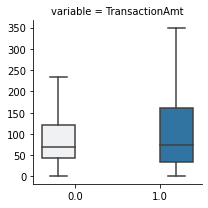

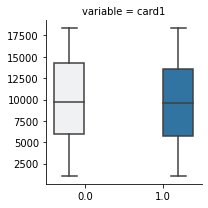

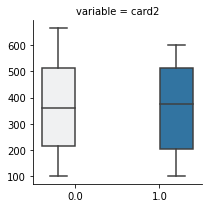

In [ ]:
melted = []
n_plot = 3 # len(cat_cols)
target_col = "isFraud"
cat_cols = num_data.columns[(num_data.dtypes == int) | (num_data.dtypes == float)]
for i in range(n_plot):
    melted.append(numerical_data.melt(id_vars=target_col,value_vars=cat_cols[i]))
    g = sns.FacetGrid(melted[i], col='variable', sharex=False,col_wrap=1)
    g.map_dataframe(sns.boxplot, x="isFraud", y="value", showfliers=False, hue = 'isFraud')
    plt.show()

Visualizzo la differenza nella distribuzione di probabilità della feature a seconda della label. 

Documentazione histplot: https://seaborn.pydata.org/generated/seaborn.histplot.html

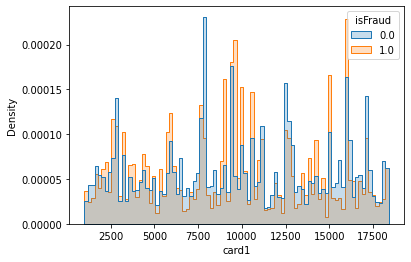

In [ ]:
sns.histplot(data=numerical_data[['card1','isFraud']], x="card1", hue="isFraud", element="step", stat="density", common_norm=False)

Calcolo le medie e le deviazioni standard per poter calcolare la variabile t ed effettuare il test di Welch.

In [ ]:
def get_stat(dataset, mean = False, std = False):
    col_to_drop = ['TransactionAmt','TransactionID','TransactionDT']
    if mean:
        means = dataset.groupby(['isFraud']).mean()
        means = means.drop(col_to_drop, axis = 1)
        return means
    if std:
        stds = dataset.groupby(['isFraud']).std()
        stds = stds.drop(col_to_drop, axis = 1)
        return stds
    else:
        print('Specificy if you want the mean or std')
    
def get_subFrame(dataset, safe = False, fraud = False):
    col_to_drop = ['TransactionAmt','TransactionID','TransactionDT','isFraud']
    if safe:
        safe_dataset = dataset[dataset['isFraud']==0].drop(col_to_drop, axis = 1)
        return safe_dataset
    if fraud:
        fraud_dataset = dataset[dataset['isFraud']==1].drop(col_to_drop, axis = 1)
        return fraud_dataset
    else:
        print('Specificy if you want the safe or fraud rows')


In [ ]:
means = get_stat(numerical_data, mean=True)
stds = get_stat(numerical_data, std=True)

In [ ]:
safe_numerical = get_subFrame(numerical_data, safe = True)
fraud_numerical = get_subFrame(numerical_data, fraud = True)

Definisco le funzioni per poter effettuare il Welch test e lo effettuo. 

$ t = \frac{\mu_{0} - \mu_{1}}{\sqrt{\frac{s_{0}^{2}}{N_{0}} + \frac{s_{1}^{2}}{N_{1}}}}$

$ \nu = \frac{(\frac{s_{0}^{2}}{N_{0}} + \frac{s_{1}^{2}}{N_{1}})^{2}}{{\frac{s_{0}^{4}}{N_{0}^{2}\nu_{0}} + \frac{s_{1}^{4}}{N_{1}^{2}\nu_{1}}}}$
 

`t` e `dof` sono due dizionari. `t` contiene i valori della variabile t, e `dof` i gradi di libertà. 

Riferimento wikipedia Welch t-test:  https://en.wikipedia.org/wiki/Welch%27s_t-test

In [ ]:
from scipy import stats

def diff(df):
    res = {}
    for col in df.columns:
        res[col] = df[col][0] - df[col][1]
    return res

def s(df_safe, df_fraud):
    res = {}
    for col in df_safe.columns:
        s0_2 = stds[col][0]**2
        s1_2 = stds[col][1]**2
        n0 = len(df_safe)
        n1 = len(df_fraud)
        res[col] = np.sqrt(s0_2 /n0 + s1_2 /n1)
    return res

def t(mean, std, df_safe, df_fraud):
    res = {}
    for col in mean.columns:
        res[col] = diff(mean)[col] / s(df_safe, df_fraud)[col]
    return res

def v(df_safe, df_fraud):
    res = {}
    for col in df_safe.columns:
        s0_2 = stds[col][0]**2
        s1_2 = stds[col][1]**2
        n0 = len(df_safe)
        n1 = len(df_fraud)
        v0 = n0 - 1
        v1 = n1 - 1
        v = ((s0_2 / n0 + s1_2 / n1)**2)/(s0_2**2/(n0**2 * v0) + s1_2**2/(n1**2 * v1))
        res[col] = np.ceil(v)
    return res


In [ ]:
t_variable = t(means, stds, safe_numerical, fraud_numerical)
dof = v(safe_numerical, fraud_numerical)

Una volta effettuato il test, scelgo il livello di significatività e vado a selezionare le feature con p-value superiore a tale livello. 

Calcolo del p-value: https://towardsdatascience.com/inferential-statistics-series-t-test-using-numpy-2718f8f9bf2f

In [ ]:
def sig_cols(t_variable, dataset, liv_sign = 0.95):
    p_value = {}
    sig_cols = 0
    num_sign_col = []
#     num_col_not_sign = []

    for col in dataset.columns:    
        p_value[col] = 1 - stats.t.cdf(t_variable[col], df = dof[col])
        if p_value[col] > liv_sign:
            num_sign_col.append(col)
            print('Feature ', col, 'has a pvalue of: ', p_value[col])
            sig_cols += 1
#         else:
#             num_col_not_sign.append(col)
#             print('Feature ', col, 'is below significancy level')
    print(len(num_sign_col), ' significative columns on ', len(dataset.columns), 'total columns')
    return num_sign_col

`num_sign_col`: lista con le colonne numeriche significative tramite test di Welch e con missing values rimpiazzati tramite MICE. 

Riferimento scrittura file testo: https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python

Riferimento lettura file testo: https://www.kite.com/python/answers/how-to-read-a-text-file-into-a-list-in-python



In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt'):
    num_sign_col = sig_cols(t_variable, safe_numerical)
    with open('num_sign_col_mice.txt', 'w') as f:
        for item in num_sign_col:
            f.write("%s " % item)
            
file = open("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/num_sign_col_mice.txt", "r")
num_sign_col = file.read()
num_sign_col = num_sign_col.split(" ")
file.close()
num_sign_col.pop()
len(num_sign_col)

118

## 2.2. Analisi feature categoriche
Analizzo il comportamento delle feature categoriche. 

Istogrammi delle feature categoriche. 

In [ ]:
done = False
if done:
  for col in categorical_col[3:10]:
      ax = sns.catplot(data = categorical_data, x=col, hue='isFraud', kind = 'count')
      ax.set(yscale="log")
      plt.show()

Inizializzo i dizionari che conterranno i conteggi e le frequenze relative a ciascuna feature. Inoltre elimino le colonne isFraud e TransactionID. 

In [ ]:
count = {}
frequencies = {}
done = False
if not done:
    categorical_col.remove('isFraud')
    categorical_col.remove('TransactionID')
    done = True

Riferimento `group_by`: https://stackoverflow.com/questions/42563209/how-to-count-subgroups-of-categorical-data-in-a-pandas-dataframe


In [ ]:
for col in categorical_col:
    count[col] = categorical_data.groupby('isFraud')[col].value_counts().unstack(fill_value=0)
    frequencies[col] = categorical_data.groupby('isFraud')[col].value_counts(normalize = True).unstack(fill_value=0)    
#     print(frequencies[col], '\n')

## Test $\chi^2$
Importo la funzione `chi2_contingency` che permette di effettuare il test $\chi^2$. 

$H_{0}$: le differenze tra le frequenze nel caso di transazioni fraudolente e non, non siano statisticamente significative, cioè che siano il frutto di noise nel dataset. 

Risultato: Se il p-value è inferiore al livello di significatività del test, allora la differenza tra le frequenze è significativa, cioè non è casuale. 

Riferimenti `chi2_contingency`: 

* https://www.geeksforgeeks.org/python-pearsons-chi-square-test/

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html

In [ ]:
def get_sign_cols(count, liv_sign = 0.95):
    from scipy.stats import chi2_contingency 

    stat = {}
    p = {}
    dof = {}
    expected = {}

    # dizionari che contengono i nomi delle feature significative e non 
    cat_col_sign = []
#     cat_col_not_sign = []

    for col in count:
        stat[col], p[col], dof[col], expected[col] = chi2_contingency(count[col]) 
        if p[col] < liv_sign:
            cat_col_sign.append(col)
            print('Feature ', col,' is significant \t Chi square: ', stat[col], '\t dof: ', dof[col], '\n')
#         else:
#             cat_col_not_sign.append(col)
#             print('Feature ', col,' is NOT significant \t Chi square: ', stat[col], '\t dof: ', dof[col], '\n')

    print('Number of significative features: ', len(cat_col_sign))
    return cat_col_sign

`cat_sign_col`: lista che contiene il nome delle colonne, con variabili categorihe, significative tramite test $\chi^{2}$. 

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt'):
    cat_sign_col = get_sign_cols(count)
    with open('cat_sign_col.txt', 'w') as f:
        for item in cat_sign_col:
            f.write("%s " % item)
            
file = open("/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/cat_sign_col.txt", "r")
cat_sign_col = file.read() # importo il file
cat_sign_col = cat_sign_col.split(" ") # le colonne sono separate dallo spazio
file.close() 
cat_sign_col.pop() # levo l'ultimo elemento che è vuoto

''

In [ ]:
print(len(cat_sign_col), ' significative features on', len(categorical_col), ' total features')

30  significative features on 31  total features


## 2.3 Analisi delle correlazioni

#### Funzioni:

* `dropColNotSign(dataset, col_sign, not_ignore = None)`: funzione per eliminare le colonne non significative dal dataset. `not_ignore`: colonna da ritenere significativa anche se non presente nella lista `col_sign`. 

* `corr_matrix_plot(dataset, corr_matrix)`: funzione per plottare la matrice di correlazione. 

* `highest_correlations(corr_matrix, tresh = 0.8)`: restituisce le features con correlazione superiore alla soglia `tresh` specificata.

* `corr_dict(corr)`: restituisce un dizionario i cui elementi sono le coppie di features correlate, con relativo valore di correlazione. 

#### Variabili: 

`col_sign` è una lista che conterrà le colonne significative, cioè quelle selezionate per portare avanti l'analisi. 

`corr_d`: dizionario con le coppie di features correlate e relativa correlazione. 

#### Riferimenti 

* Riferimento sul sort: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

- Riferimento `drop_duplicates`: https://stackoverflow.com/questions/30530663/how-to-select-distinct-across-multiple-data-frame-columns-in-pandas

* Riferimento `corr_sorted[corr_sorted>tresh]`: https://stackoverflow.com/questions/32067054/remove-rows-of-zeros-from-a-pandas-series

* Riferimento `corr_dict`: https://stackoverflow.com/questions/25929319/how-to-iterate-over-pandas-multiindex-dataframe-using-index

* Riferimento `np.isnan`: https://numpy.org/doc/stable/reference/generated/numpy.isnan.html

In [ ]:
def dropColNotSign(dataset, col_sign, not_ignore = None):
  col_not_sign = []
  if not fraud:
      for col in dataset.columns:
        if col not in col_sign and col != not_ignore:
          col_not_sign.append(col)
  dataset = dataset.drop(col_not_sign, axis=1)            
  return dataset

def corr_matrix_plot(dataset, corr_matrix):
    f = plt.figure(figsize=(20, 20))
    plt.matshow(corr_matrix, fignum=f.number)
    plt.xticks(range(dataset.shape[1]), dataset.columns, fontsize=10, rotation=90)
    plt.yticks(range(dataset.shape[1]), dataset.columns, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    
def highest_correlations(corr_matrix, tresh = 0.8):
    corr_matrix_abs = corr_matrix.abs()
    corr_matrix_abs = corr_matrix_abs.unstack()
    corr_sorted = corr_matrix_abs.sort_values(kind="quicksort")
    corr_sorted = corr_sorted[:-len(num_sign_col)] # levo i termini sulla diagonale
    corr_sorted = corr_sorted.drop_duplicates() # levo i termini doppi
    corr_sorted = corr_sorted[corr_sorted>tresh]
    return corr_sorted

def corr_dict(corr):
    corr_dict = {}
    corr_list = []
    for col1, df in corr.groupby(level=0):
        for col2 in df:
           if not np.isnan(corr.loc[col1,col2]):
                corr_dict[col1,col2] = corr.loc[col1,col2]
                corr_list.append([col1,col2])
                corr_list.append([col2,col1])
                
    return corr_dict, corr_list

In [ ]:
col_sign = num_sign_col + cat_sign_col # lista con le features significative
print('Number of significative features: ', len(col_sign))
correlation_data = dropColNotSign(numerical_data, num_sign_col) # dataset solo con le features significative
correlation_data_fraud = dropColNotSign(numerical_data, num_sign_col, not_ignore = 'isFraud') 
correlation_data_fraud = correlation_data_fraud[correlation_data_fraud['isFraud'] == 1 ]

Number of significative features:  148


In [ ]:
show_plots = False
if show_plots:
  corr_matrix = correlation_data.corr()
  corr_matrix_plot(correlation_data, corr_matrix)
  highest_corr = highest_correlations(corr_matrix)
  highest_corr= highest_corr.unstack(level = 1)

  corr_matrix_fraud = correlation_data_fraud.corr()
  corr_matrix_plot(correlation_data_fraud, corr_matrix_fraud)
  highest_corr_fraud = highest_correlations(corr_matrix_fraud)
  highest_corr_fraud = highest_corr_fraud.unstack(level = 1)

  corr_d, corr_list = corr_dict(highest_corr)
  corr_d_fraud, corr_list_fraud = corr_dict(highest_corr_fraud)

Vado ad individuare le correlazioni che ci sono solo nel caso di transazioni fraudolente. 

In [ ]:
if show_plots:
  unique_corr = []
  for item in corr_list_fraud:
      if item not in corr_list:
        unique_corr.append(item)

Fare differenza delle correlazioni nel caso fraud e safe per vedere se spuntano correlazioni diverse. 

Riferimento `scatterplot`: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

In [ ]:
done = False
if done:
  for item in unique_corr:
    sns.scatterplot(data=correlation_data[item], x=item[0], y=item[1])
    plt.show()

# 3. Training

## 3.0 Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [ ]:
def min_max_scaling(data):
  col_not_to_scale = ['isFraud','TransactionID', 'TransactionDT']
  for col in data.columns:
    if col not in col_not_to_scale:
      data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
       
  return data

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

In [ ]:
from sklearn.model_selection import train_test_split
def split(dataset, test_size):  

  y = dataset['isFraud']
  X = dataset.drop(['isFraud'], axis = 1)

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)
  return X_train, X_val, y_train, y_val

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


In [ ]:
def ap_metric(clf, X_val, y_val):
  from sklearn.metrics import precision_recall_curve
  from sklearn.metrics import plot_precision_recall_curve
  from sklearn.metrics import average_precision_score

  y_score = clf.predict_proba(X_val)
  average_precision = average_precision_score(y_val, y_score[:,1])

  disp = plot_precision_recall_curve(clf, X_val, y_val)
  disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
  return

def performance(clf, X_val, y_val):
  from sklearn.metrics import plot_roc_curve

  plot_roc_curve(model, X_val, y_val)
  plt.show()

  ap_metric(clf, X_val, y_val)
  return

def conf_matrix(clf, X_val, y_val):
  from sklearn.metrics import plot_confusion_matrix

  # disp = plot_confusion_matrix(classifier, X_val, y_val, display_labels=class_names, cmap=plt.cm.Blues, normalize=False)
  disp = plot_confusion_matrix(clf, X_val, y_val, cmap=plt.cm.Blues, normalize=None)
  disp.ax_.set_title('Confusion matrix')
  # print(title)
  print(disp.confusion_matrix)
  return

# def save_model(clf):
#   import pickle
#   with open('model.pkl','wb') as f:
#     pickle.dump(clf,f)
#   return

# def load_model():
#   import pickle
#   with open('model.pkl', 'rb') as f:
#     clf = pickle.load(f)
#   return clf



### Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

def col_not_sign(dataset, sign_cols):
  col_not_sign = []
  for col in dataset.columns:
    if col not in sign_cols and col != 'TransactionID':
      col_not_sign.append(col)
  col_not_sign.append('isFraud')
  return col_not_sign

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')

## 3.1 Categorical Boost

Con 2000 iterazioni: AUC= 0.9, AP= 0.7

Con 4000 iterazioni: AUC= 0.92, AP= 0.73

Non è stato fatto nè il one hot encoding nè l'easy ensemble.

Documentazione CatBoost: https://catboost.ai/docs/concepts/python-quickstart.html

Categorical features parameter: https://github.com/catboost/catboost/issues/934

gpu: https://catboost.ai/docs/features/training-on-gpu.html

Riferimento salvataggio del modello: https://stackoverflow.com/questions/51895761/how-to-correctly-load-pretrained-model-in-catboost-in-python

In [ ]:
load = False
if load:
  model = CatBoostClassifier()
  model.load_model('catboost')

In [ ]:
cat = False
if cat:
  !pip install catboost
  
  X_train, X_val, y_train, y_val = split(data, test_size = 0.2)
  del data
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
if cat:
  from catboost import CatBoostClassifier, Pool
  model = CatBoostClassifier(iterations=4000, depth=10, learning_rate=1, task_type="GPU",
                            cat_features = cat_sign_col, loss_function='CrossEntropy', verbose=False)
  model.fit(X_train, y_train)

In [ ]:
del X_train, y_train

In [ ]:
save = False
if save:
  model.save_model('catboost')


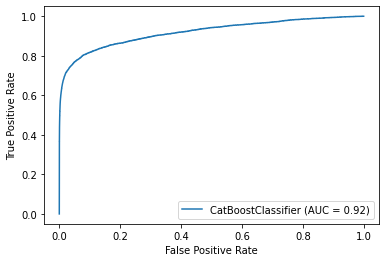

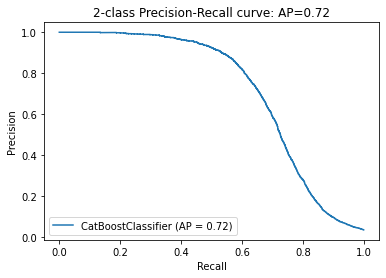

In [ ]:
if cat:
  performance(model, X_val, y_val)

[[113424    429]
 [  1789   2465]]


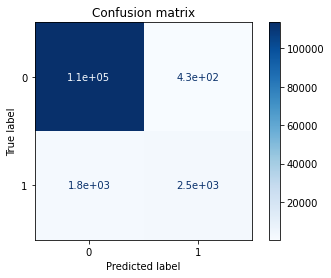

In [ ]:
conf_matrix(model, X_val, y_val)

## 3.2 One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [ ]:
data = pd.get_dummies(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [ ]:
def select_days(dataset, days):
  sec = 86400
  tot = days * sec
  dataset = dataset[dataset['TransactionDT'] < tot]
  return dataset

data = select_days(data, 60)

Splitto il dataset in train, validation e test set. 

In [ ]:
X_train, X_val, y_train, y_val = split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## 3.3 Undersampling: Easy Ensemble

L'easy ensemble tramite un metodo unsupervised divide il dataset in diversi dataset undersampled. 

Documentazione easy ensemble: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.ensemble.EasyEnsemble.html#imblearn.ensemble.EasyEnsemble

Esempio applicazio ee: http://glemaitre.github.io/imbalanced-learn/auto_examples/ensemble/plot_easy_ensemble.html?highlight=easy%20ensemble

In [ ]:
from imblearn.ensemble import EasyEnsemble 
n_subsets = 5
ee = EasyEnsemble(random_state=42, n_subsets=n_subsets)
X_trainres, y_trainres = ee.fit_sample(X_train, y_train)

## 3.4 XGBoost

Provo a trainare un random forest con cross validation sui vari dataset splittati attraverso easy ensemble. 

ROC curve: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-roc-curve-visualization-api-py

XGBoost: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

gpu_hist method: https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-hist-and-gpu-hist-tree-method

In [ ]:
X_val = X_val.values

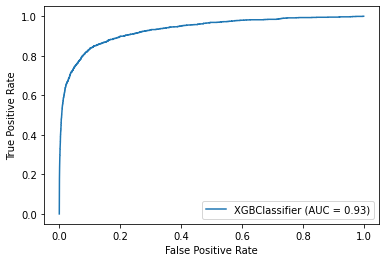

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators = 4000, max_depth = 20, alpha=0.5, objective='binary:logistic', learning_rate = 1, tree_method='gpu_hist') #learning_rate=0.05)
# clf = RandomForestClassifier(n_estimators = 4000, max_depth=10, random_state=0, oob_score = True)
# clf.fit(X_train, y_train)
clf.fit(X_trainres[0], y_trainres[0])
plot_roc_curve(clf, X_val, y_val)
plt.show()

AP max = 0.64

AP: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

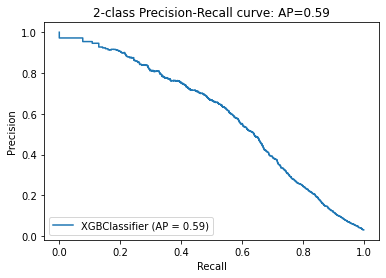

In [ ]:
ap_metric(clf, X_val, y_val)

Text(0, 0.5, 'Feature Importance Score')

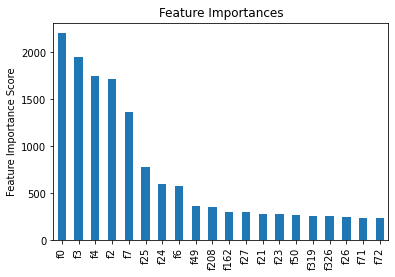

In [ ]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp[:20].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### ROC AUC curve

Riferimento: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

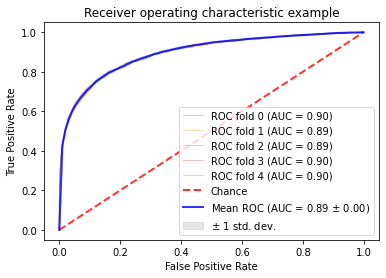

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier

# classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = XGBClassifier()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i in range(n_subsets):
    classifier.fit(X_trainres[i], y_trainres[i])
    viz = plot_roc_curve(classifier, X_val, y_val,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

## 3.2 Model selection


In [ ]:
X_valres = X_val[:1000].to_numpy()
y_valres = y_val[:1000].to_numpy()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier()
model.fit(X_trainres[0], y_trainres[0])
# make predictions for test data
y_pred = model.predict(X_valres)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_valres, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.90%


Provo ad usare AdaBoost su un singolo subset. 

In [ ]:
# https://scikit-learn.org/stable/modules/ensemble.html
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# for i in range(n_set):
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X_train[0], y_train[0], cv=5)
scores

In [ ]:
# valuto le performance del modello
clf.fit(X_train[0], y_train[0])
y_pred = clf.predict(X_val[0])
cm = confusion_matrix(y_val[0], y_pred)
cm

Prova del balanced random forest di imblearn. 

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import balanced_accuracy_score
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.metrics import geometric_mean_score

# brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# brf.fit(X_train[i], y_train[i])
# y_pred_brf = brf.predict(X_val[i])

# print('Balanced Random Forest classifier performance:')
# print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'
#       .format(balanced_accuracy_score(y_val[i], y_pred_brf),
#               geometric_mean_score(y_val[i], y_pred_brf)))
# cm_brf = confusion_matrix(y_val[i], y_pred_brf)
# cm_brf

Oversampling

SMOTENC serve per lavorare con le feature categoriche. 

Riferimento SMOTENC: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTENC.html

In [ ]:
# def smote(X, y):
#   from imblearn.over_sampling import SMOTENC
  
#   categorical_features = np.arange(177, 445)
#   sm = SMOTENC(random_state=42, categorical_features = categorical_features)

#   X_res, y_res = sm.fit_resample(X, y)

#   return X_res, y_res

# X_trainres, y_trainres = smote(X_train,y_train)
# X_trainres